# Dự đoán điểm chuẩn đại học năm 2023

## Bài tập lớn môn học Data Warehouse - Decision System 

GVHD: Th.S. Bùi Tiến Đức


### Sinh viên thực hiện

Nguyễn Quang Huy - 1916081
Trần Phúc Anh - 2010133
Phan Hoàng Phúc - 
Trần Thiện Nhân

## Giới thiệu đề tài

Trong đề tài lần này nhóm em sẽ thực hiện 1 quy trình ETL để thu thập dữ liệu điểm chuẩn từ nhiều nguồn, lưu trữ lại trong 1 staging database sau đó xử lý và lưu trong data warehouse của nhóm.
Với tập dữ liệu có được, nhóm sẽ cố gắng xây dựng 1 trang web tra cứu điểm cũng như tìm kiếm theo nhu cầu, kèm theo đó là dự đoán điểm chuẩn trong đợt tuyển sinh sắp tới vào năm 2023.

Cấu trúc đề tài của nhóm sẽ bao gồm:

* Quy trình ETL để thu thập dữ liệu lưu vào Staging Database

    * Extract
    * Transform
    * Load

* Quy trình xử lý dữ liệu và tạo Data Warehouse lưu trữ dữ liệu


* Xây dựng model dự đoán điểm chuẩn trong năm học 2023

    * Pre-processing dữ liệu
    * Trực quan hóa dữ liệu
    * Xây dựng model
    * Kết quả của model

* Một số hình ảnh từ trang Web mà nhóm xây dựng



### Cài đặt thư viện phục vụ cho việc crawling dữ liệu

In [ ]:
pip install bs4
pip install pandas

## Thu thập dữ liệu điểm chuẩn từ nhiều nguồn

Để thực hiện việc thu thập dữ liệu điểm chuẩn, đầu tiên ta cần thu thập mã trường từ mọi trường trên Việt Nam. Sau đó, ta sẽ dựa vào mã trường để thu thập điểm chuẩn của từng trường

### Thu thập mã các trường Đại học trên toàn nước

### Đầu tiên, ta cần import thư viện

In [ ]:
from bs4 import BeautifulSoup
import requests

### Sau đó, ta sẽ viết module cho việc thu thập mã trường từ nguồn dữ liệu gốc

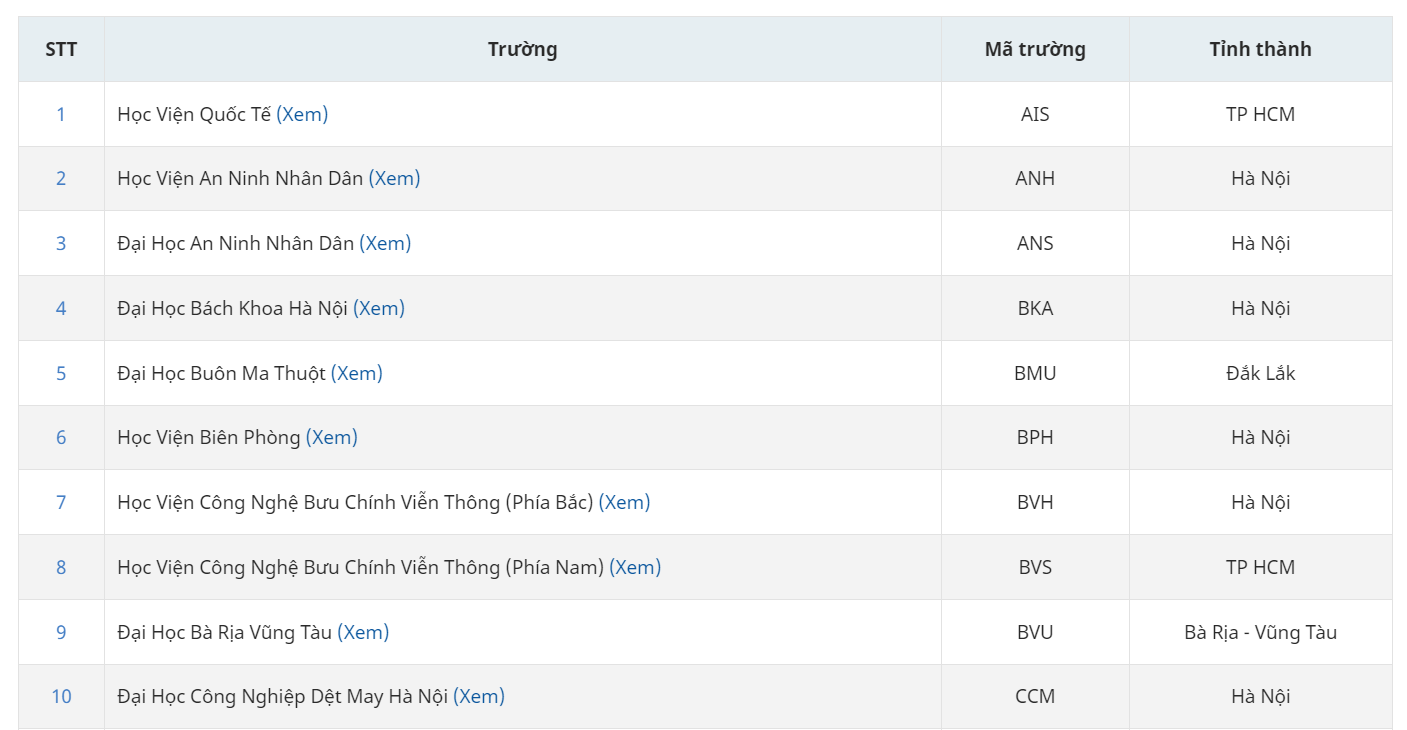

Đây là hình ảnh từ dữ liệu mà ta sẽ thu thập, như ta thấy ở trên mỗi trường sẽ có 1 mã. Dữ liệu gốc bao gồm rất nhiều trường trải dài trong 6 trang dữ liệu, vì vậy ta cần phải extract qua từng trang bằng module như sau

In [ ]:
def CrawlCollegeID():
    numberOfPage = 16
    CollegeID = []
    baseURL = "https://vietnamnet.vn/"
    for i in range(numberOfPage):
        page = requests.get(f"{baseURL}giao-duc/diem-thi/tra-cuu-diem-chuan-cd-dh-2023-page{i}")
        soup = BeautifulSoup(page.text, 'html.parser')
        CollegeIDTableInfo = soup.find("div", {"class": "dataTable__main"}).find("table").find("tbody").findAll("tr")
        for College in CollegeIDTableInfo:
            dataList = []
            for data in College:
                if data == '\n':
                    continue
                if data.find("a"):
                    shortURL = data.find("a").get("href")
                    dataList.append(f"{baseURL}{shortURL}".replace("2023","year"))
                    data = data.getText()
                    dataList.append(data[:len(data) - 6])
                else:
                    data = data.getText()
                    dataList.append(data)
            CollegeID.append(dataList)
    return CollegeID

  

Đầu tiên, ta nhập URL của nguồn dữ liệu ta cần lấy, sau đó với mỗi trang dữ liệu ta sẽ sử dụng hàm soup.find để lấy được từng record và lưu vào mảng collegeID mà ta đã tạo, chứa mã trường của từng trường trong cả nước.
Lưu ý, điều thuận tiện trong nguồn dữ liệu này là mỗi trường đều có cả đính kèm luôn cả đường link trỏ tới điểm chuẩn của trường, ta cũng sẽ tận dụng điều này để lưu lại và tận dụng khi xử lý dữ liệu điểm

## Kết quả sau khi Crawl mã trường

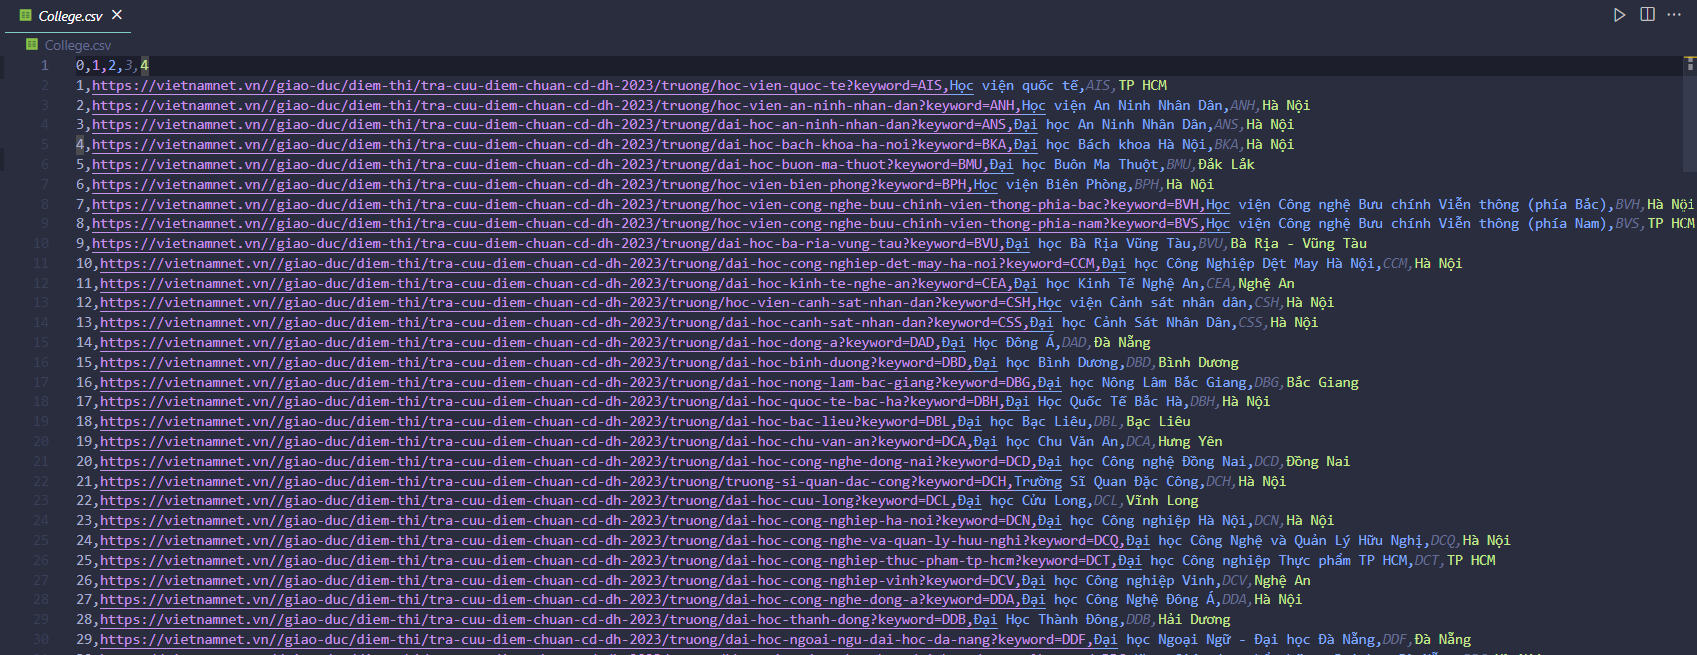

Với mỗi mã trường, ta sẽ có cả link trỏ tới bảng điểm chuẩn của trường đó, kèm theo tên trường và vị trí của trường

## Thu thập dữ liệu điểm chuẩn

### Import thư viện và module thu thập dữ liệu trường vừa lấy ở trên

In [ ]:
from CollegeID import *
from bs4 import BeautifulSoup
import requests

### Lấy danh sách trường trên cả nước

In [ ]:

collegeList = CrawlCollegeID()

### Transform đồng thời Load dữ liệu điểm chuẩn của từng trường trong cả nước

In [ ]:
def CrawlGradeByCollege():
    CollegeGrade = []
    for college in collegeList:
        for year in range(2016,2023):
            url = college[1].replace("year",f"{year}")
            page = requests.get(url)
            soup = BeautifulSoup(page.text, 'html.parser')
            if not soup.find("table"):
                continue
            else:
                GradeTableInfo = soup.find("div", {"class": "dataTable__main"}).find("table").find("tbody").findAll("tr")
            for Grade in GradeTableInfo:
                dataList = []
                dataList.append(college[3])
                for data in Grade:
                    if data == '\n':
                        continue
                    if data.find("a"):
                        data = data.getText()
                        dataList.append(data[:len(data) - 6])
                    else:
                        data = data.getText()
                        dataList.append(data)
                dataList.append(year)
                CollegeGrade.append(dataList)

    return CollegeGrade

Trong module trên, đầu tiên ta đi qua từng năm (từ năm 2016 tới năm 2022), trong mỗi năm ta sẽ đi tới nguồn dữ liệu điểm chuẩn trong năm đó, sử dụng nguồn dữ liệu mã trường để crawl điểm chuẩn thuộc từng trường. Nếu dữ liệu có thêm đường link, ta sẽ transform để xử lý đường link đó

## Load dữ liệu ra file csv

### Import thư viện

In [ ]:
from Grade import *
from CollegeID import * 
import pandas as pd
import json

## Module load dữ liệu

In [ ]:
def LoadToCSV():


    GradeList = CrawlGradeByCollege()



    CollegeListDF = pd.DataFrame(CollegeList)
    GradeListDF = pd.DataFrame(GradeList)


    CollegeListDF.to_csv('College.csv', index=False, encoding='utf-8')
    GradeListDF.to_csv('Grade.csv', index=False, encoding='utf-8')

#### Gọi hàm load dữ liệu

In [ ]:
LoadToCSV()

### Kết quả

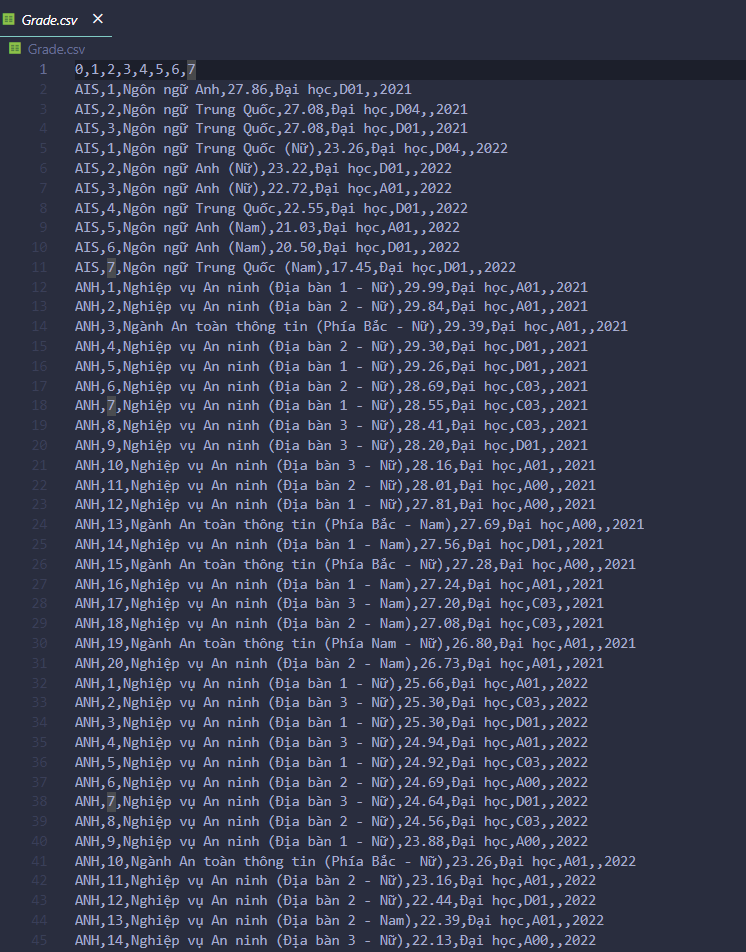

Dữ liệu bao gồm 18047 rows, với các trường thuộc tính:

* Mã trường
* Tên ngành
* Điểm chuẩn
* Hệ
* Khối thi
* Ghi chú (nếu có)
* Năm thi

# Load dữ liệu lên Staging Database

Trong phase này, nhóm quyết định sẽ sử dụng 1 database trên Cloud là IBM DB2. Lý do nhóm chọn là vì Db2 cung cấp free storage khá nhiều, hỗ trợ dữ liệu ít thuộc tính nhưng nhiều records. Ngoài ra, việc sử dụng cloud sẽ phù hợp để có thể truy cập được từ nhiều nguồn, tiện ích cho việc nhóm làm web. Sau khi xuất ra file csv, nhóm load file này lên cloud storage như sau.

Bảng College List của nhóm

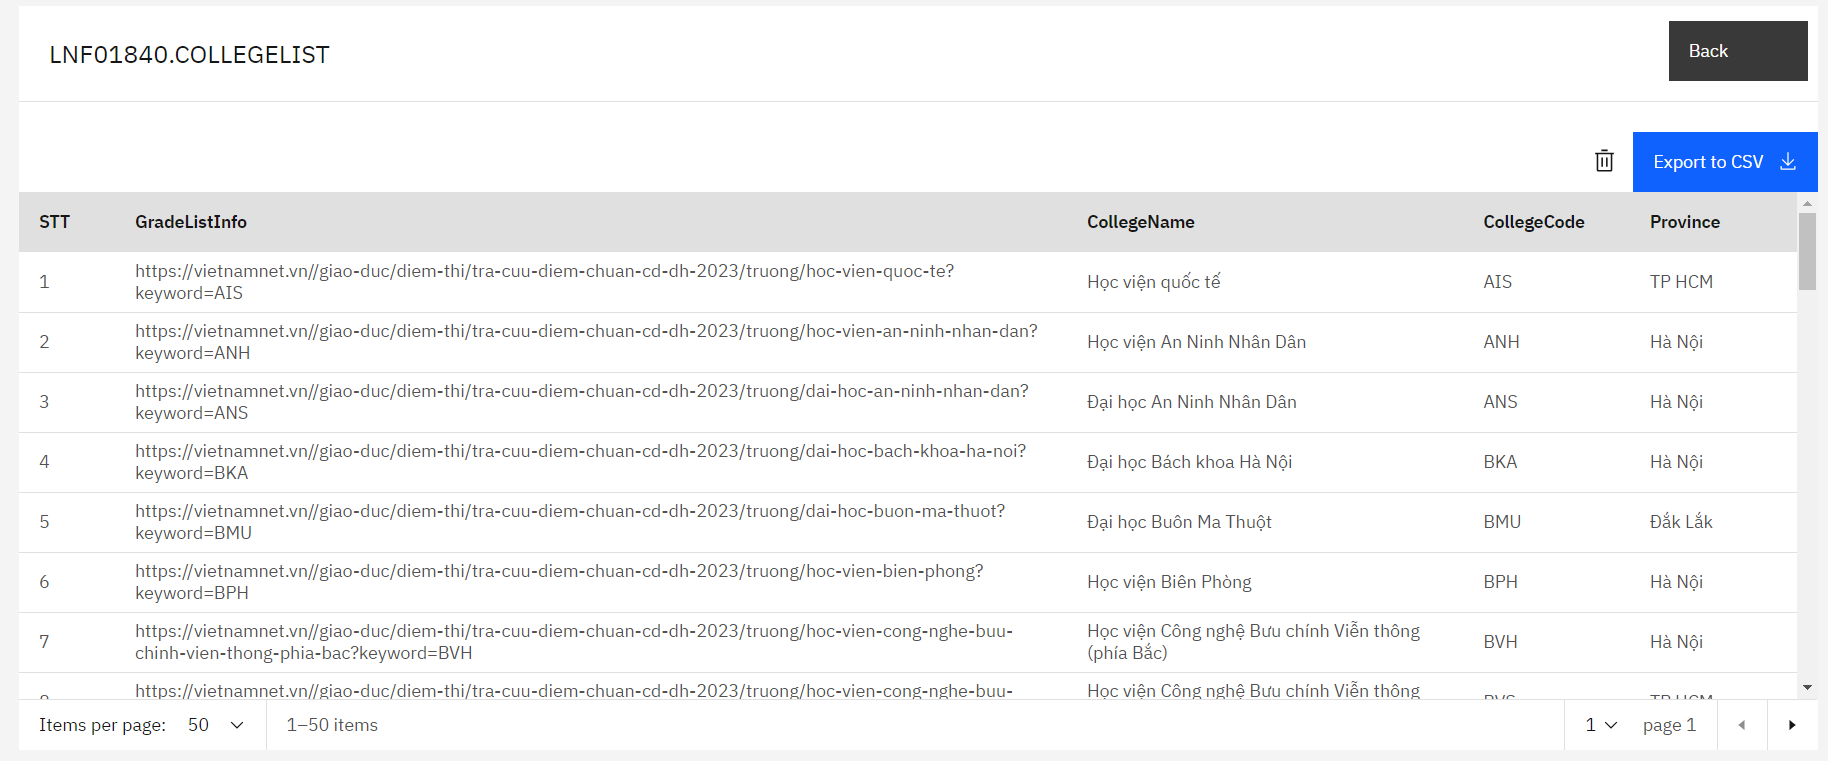

Bảng Grade List của nhóm

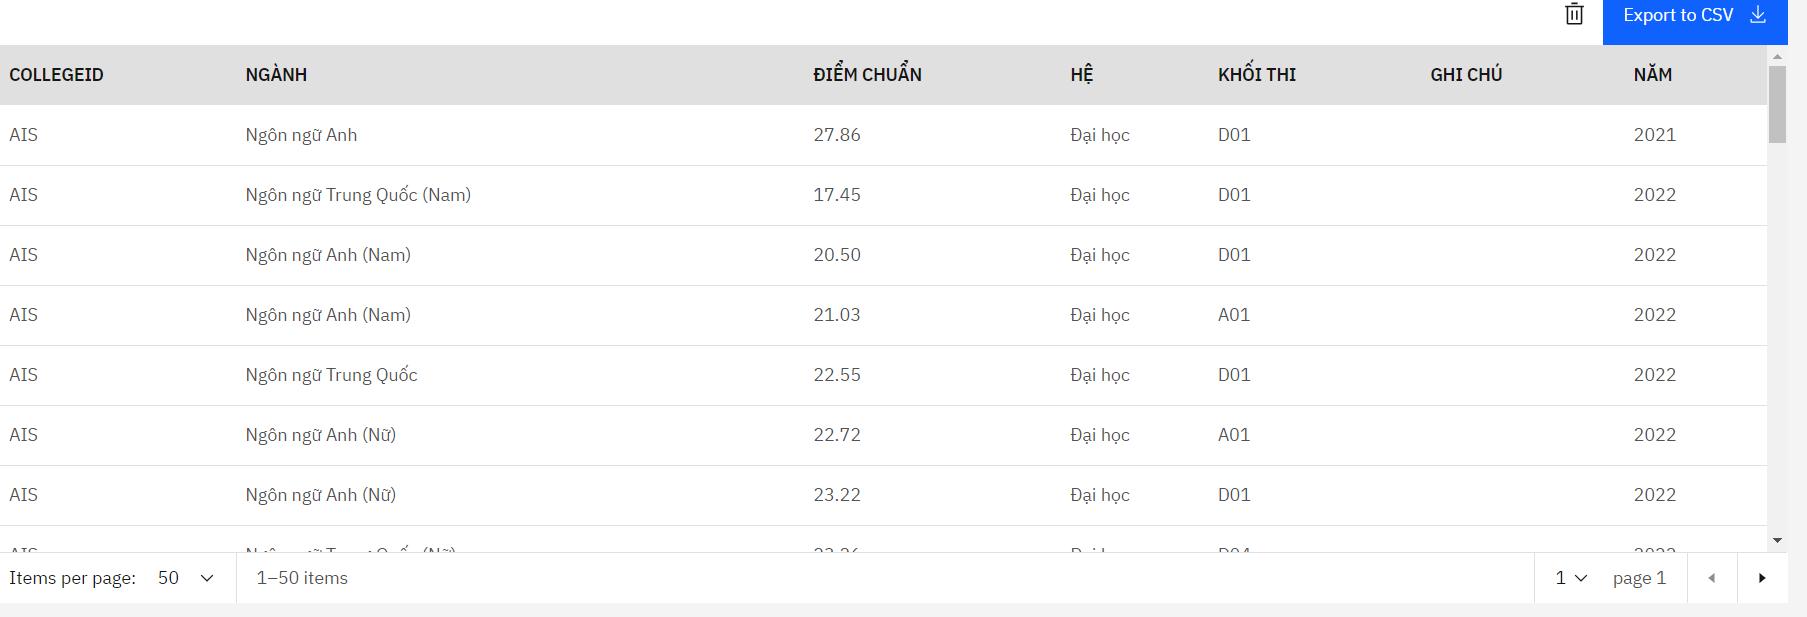

Với việc hoàn thành xong phần Staging, nhóm tiếp tục xử lý và load lên 1 Data Warehouse khác

# Xử lý dữ liệu và load lên Data Warehouse

Data Warehouse mà nhóm chọn lựa là Big Query của Google Cloud. Sở dĩ nhóm thấy đây là sự lựa chọn hợp lý vì Google Cloud hỗ trợ khá nhiều đối với tài khoản sinh viên, service Big Query của Google Cloud có khả năng chứa rất nhiều records và hỗ trợ query số lượng lớn.

Dữ liệu bảng University của nhóm

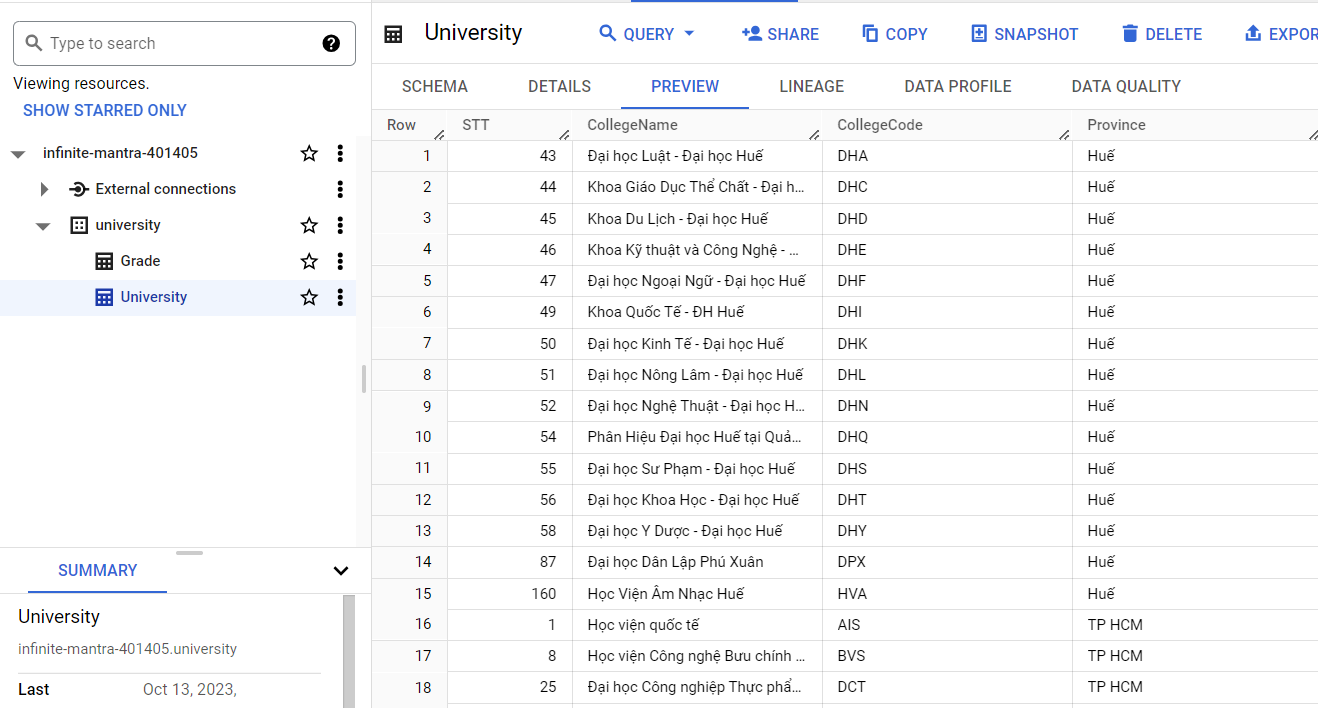

Dữ liệu bảng Grade của nhóm

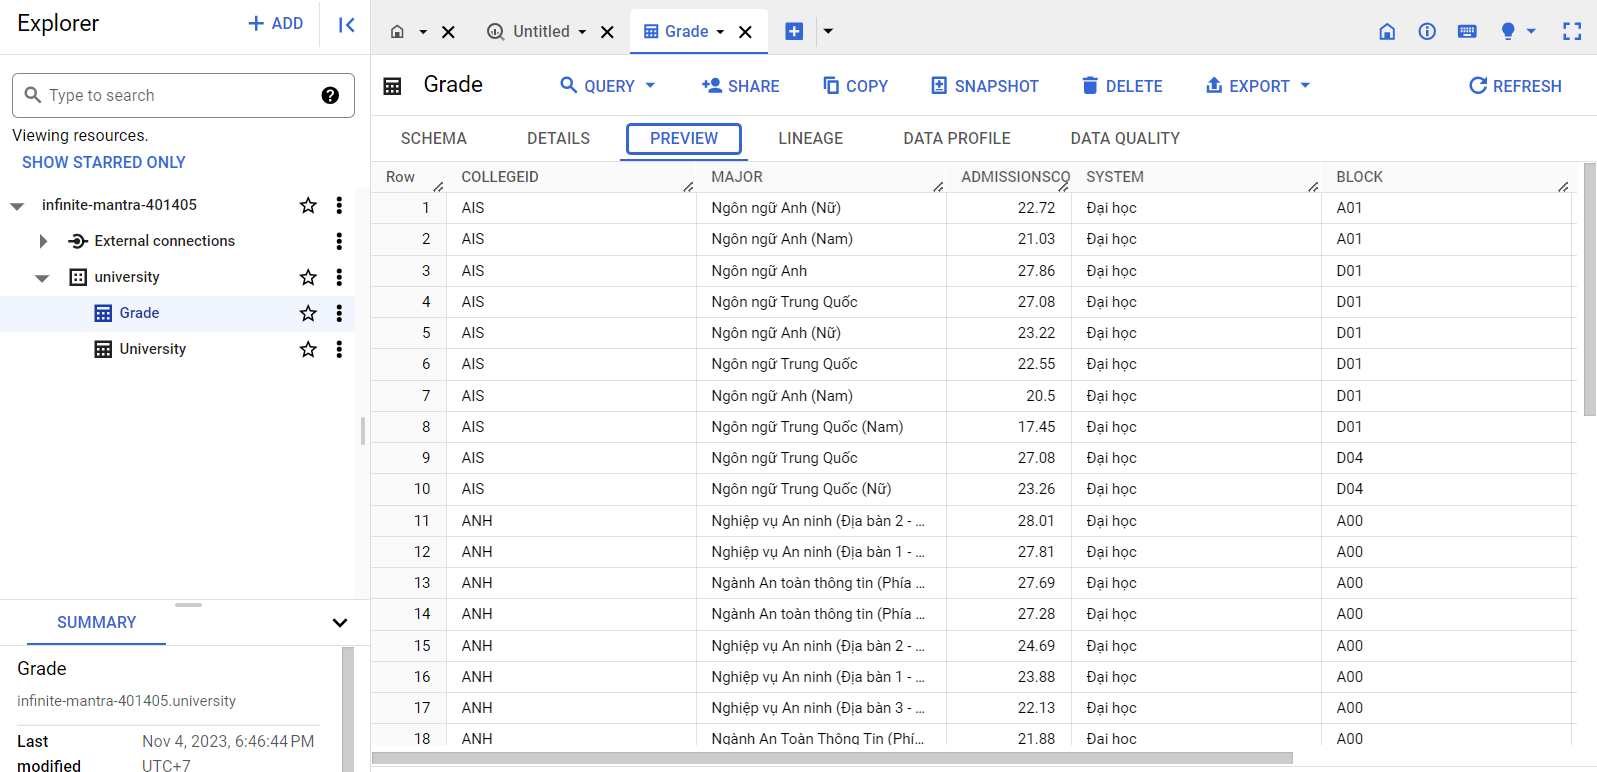


Trong cả 2 bảng, nhóm đã lược bỏ bớt cột chứa đường link trỏ tới data source để extract nhằm giúp giảm dung lượng bảng, đồng thời bỏ cột ghi chú vì dữ liệu trong cột này là không đáng kể và không dùng tới.